# Comparison of terms with OOMMF

In this notebook, we compare calculations related to different energy and dynamics terms done by OOMMF and discretisedfield.

In [1]:
import micromagneticmodel as mm
import numpy as np
import oommfc as oc

import discretisedfield as df

## Energy terms

For comparisons we use skyrmion magnetisation field.

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:11]... (2.2 s)


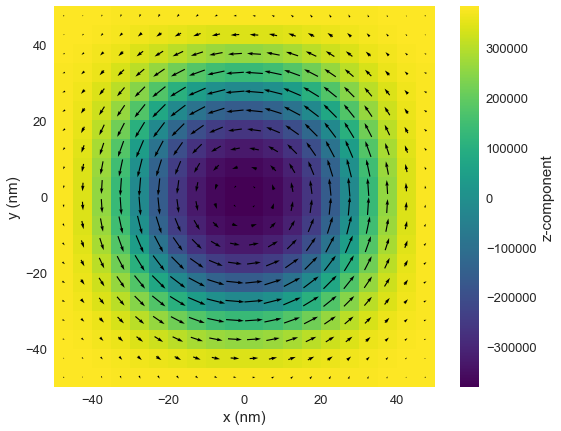

In [2]:
# Geometry
L = 100e-9
thickness = 5e-9
cell = (5e-9, 5e-9, 5e-9)
p1 = (-L / 2, -L / 2, 0)
p2 = (L / 2, L / 2, thickness)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell, bc={"neumann": 0})

# Parameters
mu0 = 4 * np.pi * 1e-7
Ms = 3.84e5
A = 8.78e-12
D = 1.58e-3
K = 1e4
u = (0, 0, 1)
H = (0, 0, 1e5)
system = mm.System(name="skyrmion")
system.energy = (
    mm.Exchange(A=A)
    + mm.DMI(D=D, crystalclass="T")
    + mm.Zeeman(H=H)
    + mm.UniaxialAnisotropy(K=K, u=u)
)


def m_initial(point):
    x, y, z = point
    if x**2 + y**2 < (L / 4) ** 2:
        return (0, 0, -1)
    else:
        return (0, 0, 1)


system.m = df.Field(mesh, dim=3, value=m_initial, norm=Ms)

md = oc.MinDriver()
md.drive(system)

system.m.plane("z").mpl(figsize=(9, 7))

### Magnetisation

$$\mathbf{m} = \frac{\mathbf{M}}{M_\text{s}}$$

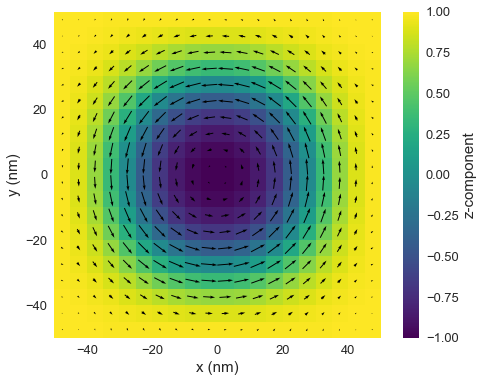

In [3]:
m = system.m.orientation

m.plane("z").mpl(scalar_clim=(-1, 1))

In [22]:
m1 & m2

-0.9653540724785998

In [4]:
m @ m

Field(mesh=Mesh(region=Region(p1=(-5e-08, -5e-08, 0.0), p2=(5e-08, 5e-08, 5e-09)), n=(20, 20, 1), bc='xyz', subregions={}), dim=1)

### Zeeman

Add d.cross, df.dot

| property | equation in continuous form | discretisedfield form |
|-|-|-|
| Energy density | $w = -\mu_{0}M_\text{s}\mathbf{m}\cdot\mathbf{H}$ | `- mu0 * Ms * m @ H` |
| Energy | $E = -\int_{V}\mu_{0}M_\text{s}\mathbf{m}\cdot\mathbf{H} dV$ | `(- mu0 * Ms * m @ H).volume_integral` |
| Effective field | $\mathbf{H}_\text{eff} = \mathbf{H}$ | `H` |

#### Energy density

In [5]:
wdf = -mu0 * Ms * m @ H
woc = oc.compute(system.energy.zeeman.density, system)
wdf.allclose(woc)

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.2 s)


True

#### Energy

In [6]:
Edf = (-mu0 * Ms * m @ H).volume_integral
Eoc = oc.compute(system.energy.zeeman.energy, system)
print(f"df: {Edf}")
print(f"oc: {Eoc}")
print(f"rerr: {abs(Edf-Eoc)/Edf * 100} %")

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.6 s)
df: -1.0347218597966675e-18
oc: -1.0347218598e-18
rerr: -3.220610979870561e-10 %


#### Effective field

In [7]:
Hdf = df.Field(mesh, dim=3, value=H)
Hoc = oc.compute(system.energy.zeeman.effective_field, system)
Hdf.allclose(Hoc)

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.2 s)


True

## Uniaxial anisotropy

| property | equation in continuous form | discretisedfield form |
|-|-|-|
| Energy density | $w = K |\mathbf{m} \times \mathbf{u}|^{2}$ | `K * abs(m & u)**2` |
| Energy | $E = \int_{V}K |\mathbf{m} \times \mathbf{u}|^{2} dV$ | `(K * abs(m & u)**2).volume_integral` |
| Effective field | $\mathbf{H}_\text{eff} = \frac{2K}{\mu_{0}M_\text{s}} (\mathbf{m} \cdot \mathbf{u})\mathbf{u}$ | `2 * K / (mu0 * Ms) * (m @ u) * u` |

#### Energy density

In [8]:
wdf = K * (m & u).norm ** 2
woc = oc.compute(system.energy.uniaxialanisotropy.density, system)
wdf.allclose(woc)

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.1 s)


True

#### Energy

In [9]:
Edf = (K * (m & u).norm ** 2).volume_integral
Eoc = oc.compute(system.energy.uniaxialanisotropy.energy, system)
print(f"df: {Edf}")
print(f"oc: {Eoc}")
print(f"rerr: {abs(Edf-Eoc)/Edf * 100} %")

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.2 s)
df: 2.0433559012028932e-19
oc: 2.0433559012e-19
rerr: 1.4159198880882791e-10 %


#### Effective field

In [10]:
Hdf = 2 * K / (mu0 * Ms) * (m @ u) * u
Hoc = oc.compute(system.energy.uniaxialanisotropy.effective_field, system)
Hdf.allclose(Hoc)

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.4 s)


True

## Exchange

| property | equation in continuous form | discretisedfield form |
|-|-|-|
| Energy density | $w = - A \mathbf{m} \cdot \nabla^{2} \mathbf{m}$ | `- A * m @ m.laplace` |
| Energy | $E = -\int_{V} A \mathbf{m} \cdot \nabla^{2} \mathbf{m} dV$ | `(- A * m @ m.laplace).volume_integral` |
| Effective field | $\mathbf{H}_\text{eff} = \frac{2A}{\mu_{0}M_\text{s}} \nabla^{2} \mathbf{m}$ | `2 * A / (mu0 * Ms) * m.laplace` |

#### Energy density

In [11]:
wdf = -A * m @ m.laplace
woc = oc.compute(system.energy.exchange.density, system)
wdf.allclose(woc)

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.1 s)


True

#### Energy

In [12]:
Edf = (-A * m @ m.laplace).volume_integral
Eoc = oc.compute(system.energy.exchange.energy, system)
print(f"df: {Edf}")
print(f"oc: {Eoc}")
print(f"rerr: {abs(Edf-Eoc)/Edf * 100} %")

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.1 s)
df: 1.7438374237954543e-18
oc: 1.7438374238e-18
rerr: 2.606653460188577e-10 %


#### Effective field

In [13]:
Hdf = 2 * A / (mu0 * Ms) * m.laplace
Hoc = oc.compute(system.energy.exchange.effective_field, system)
Hdf.allclose(Hoc)

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.2 s)


True

## DMI (T)

| property | equation in continuous form | discretisedfield form |
|-|-|-|
| Energy density | $w = D \mathbf{m} \cdot (\nabla \times \mathbf{m})$ | `D * m @ m.curl` |
| Energy | $E = \int_{V} D \mathbf{m} \cdot (\nabla \times \mathbf{m}) dV$ | `(D * m @ m.curl).volume_integral` |
| Effective field | $\mathbf{H}_\text{eff} = -\frac{2D}{\mu_{0}M_\text{s}} (\nabla \times \mathbf{m})$ | `- 2 * D / (mu0 * Ms) * m.curl` |

#### Energy density

In [14]:
wdf = D * m @ m.curl
woc = oc.compute(system.energy.dmi.density, system)
wdf.allclose(woc)

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.2 s)


True

#### Energy

In [15]:
Edf = (D * m @ m.curl).volume_integral
Eoc = oc.compute(system.energy.dmi.energy, system)
print(f"df: {Edf}")
print(f"oc: {Eoc}")
print(f"rerr: {abs(Edf-Eoc)/Edf * 100} %")

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.1 s)
df: -4.350588323927945e-18
oc: -4.35058832393e-18
rerr: -4.724309182153037e-11 %


#### Effective field

In [16]:
Hdf = -2 * D / (mu0 * Ms) * m.curl
Hoc = oc.compute(system.energy.dmi.effective_field, system)
Hdf.allclose(Hoc)

Running OOMMF (ExeOOMMFRunner) [2020/06/08 10:12]... (2.1 s)


True